In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from datasets.unet_dataset import UNetDataset
from models.unet import UNet

from scripts.train import train
from scripts.validate import validate

from utils.image import torch_to_numpy


c:\Users\ubar\Envs\mva_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, let's load the datasets :

In [2]:
# data paths for train and validation
val_dir = "challenge_data/validation/validation"
train_dir = "challenge_data/train/train"

# data augmentation
val_transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(size=(110,80))])
train_transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(size=(110,80)),
                        transforms.RandomAffine(degrees=(0, 0), translate=(0., 0.), scale=(0.8, 1.2))])

# train and validation datasets
val_dataset = UNetDataset(val_dir, transforms=val_transform)
train_dataset = UNetDataset(train_dir, transforms=train_transform)

Some plots of the dataset : 

- Inputs : 

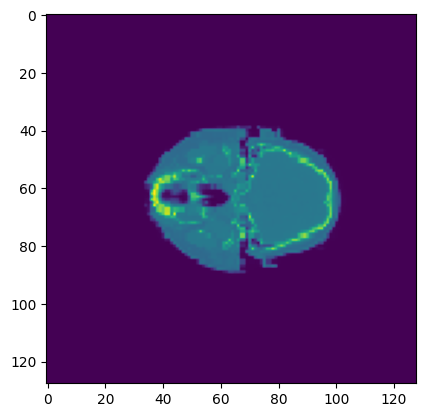

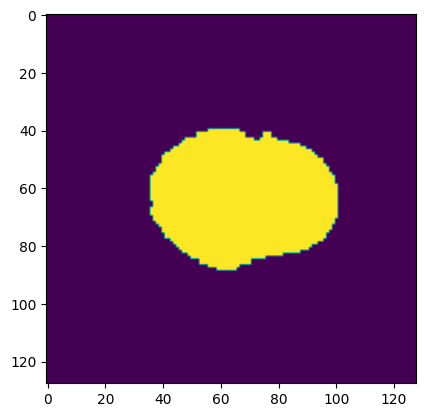

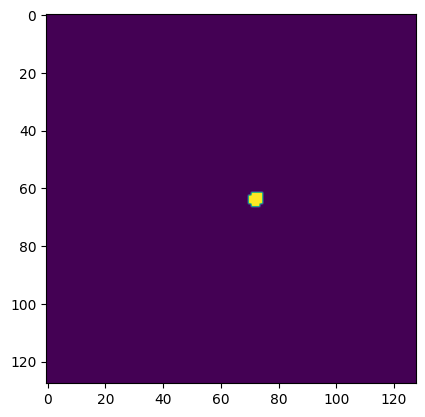

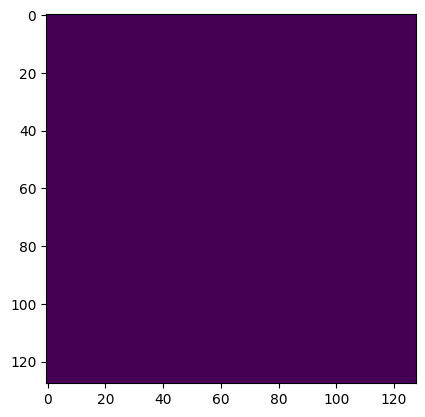

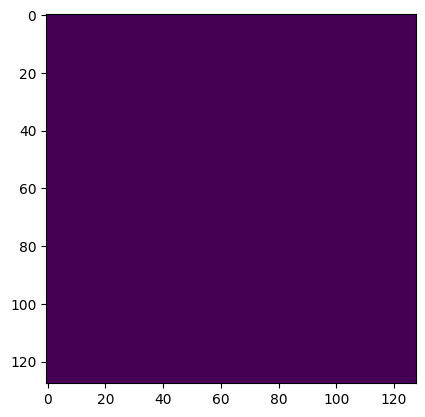

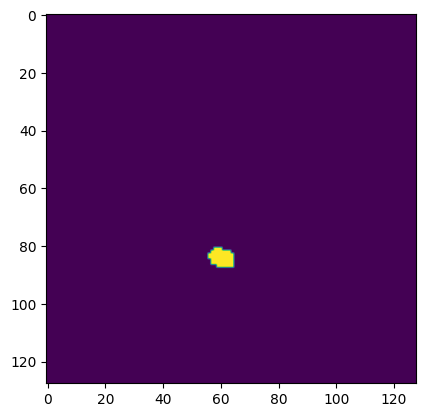

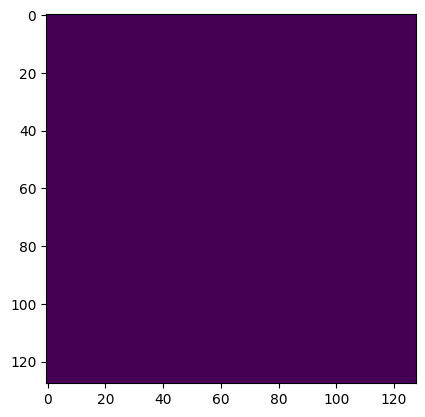

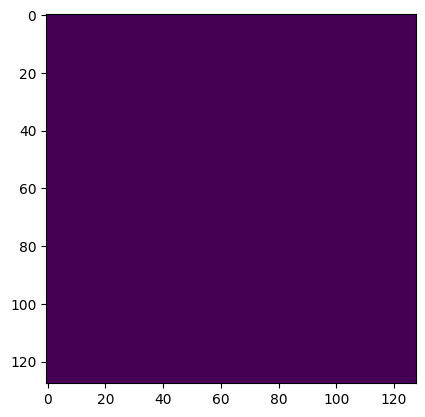

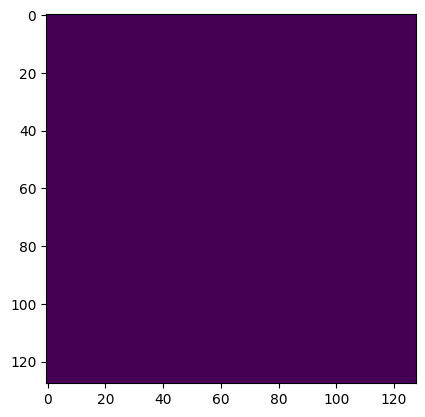

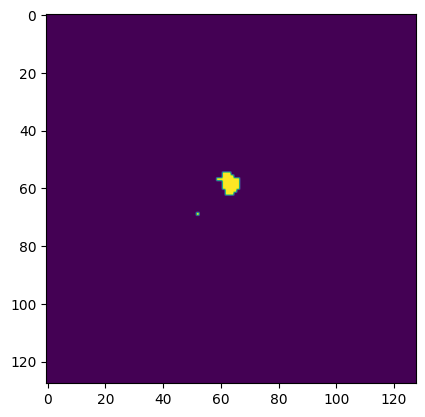

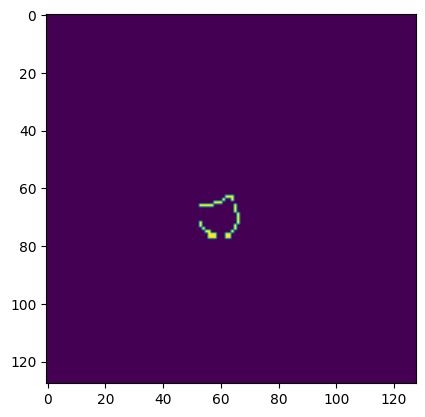

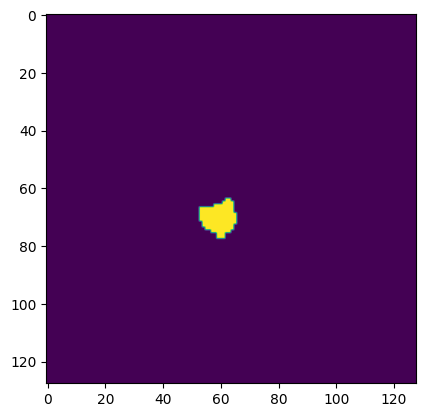

In [3]:
# pick an element of the dataset
elem = next(iter(train_dataset))
    
# show CT scans, possible dose mask and 10 organ masks
for el in elem['input'][0]:
    m = nn.ZeroPad2d((24,24, 9, 9))
    plt.figure()
    plt.imshow(torch_to_numpy(m(el.unsqueeze(0).unsqueeze(0)).detach().cpu()[0]))
    plt.show()

Labels : 

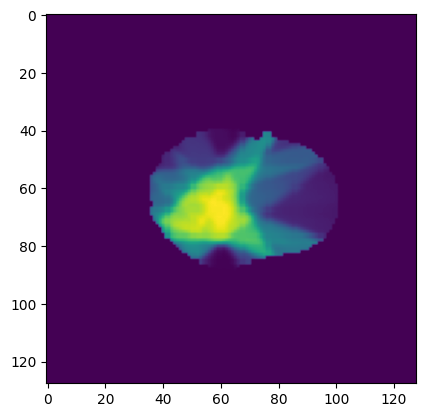

In [4]:
# pick label corresponding to the inputs above
label=elem["label"]
plt.figure()
plt.imshow(torch_to_numpy(m(label).detach().cpu()))
plt.show()

Let's build our model : 

In [5]:
# the model takes an input with 12 channels : CT scan, possible dose mask, 10 organ masks
model = UNet(n_channels=12)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


Train the model : 

In [6]:
train(model.cuda(), train_dataset, val_dataset, batch_size=32)

epoch 0
[1,   244] loss: 3.203


100%|██████████| 75/75 [01:28<00:00,  1.18s/it]


val loss :  0.6079794046640591
epoch 1
[2,   244] loss: 1.458


100%|██████████| 75/75 [01:33<00:00,  1.25s/it]


val loss :  0.6664472029620924
epoch 2


Load our best model : 

In [ ]:
model = UNet(n_channels=12).cuda().eval()
#path leading to the model
PATH = "models_ckpt/modelunet034.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Validate the model : 

In [ ]:
validate(model.cuda(), val_dataset)

100%|██████████| 75/75 [01:33<00:00,  1.24s/it]

val loss :  0.38624177072464283


0.38624177072464283

Sample example : 

In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
# pick one example of the validation set
val_sample = next(iter(val_loader))
val_elem = [val_sample["input"][0].cuda(), val_sample["input"][1].cuda()]
m = nn.ZeroPad2d((24,24, 9, 9))
out = m(model(val_elem))
out = torch.multiply(out, val_sample["possible_dose_mask"].cuda().unsqueeze(1))

Left : Prediction

Right : Groundtruth

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


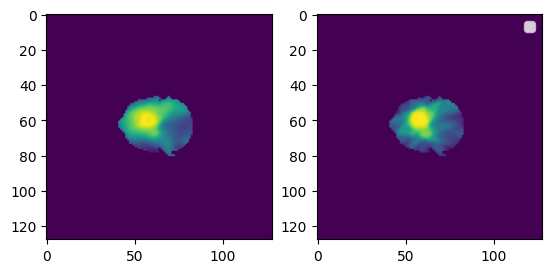

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(torch_to_numpy(out[0].cpu()))
plt.subplot(1,2,2)
plt.imshow(torch_to_numpy(m(val_sample["label"])[0].cpu()))
plt.legend()
plt.show()